In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Reading the CSV
df = pd.read_csv('rfm_data_customer.csv')

In [4]:
df.head()

,customer_id,revenue,most_recent_visit,number_of_orders,recency_days
0,22086,777,2006-05-14,9,232
1,2290,1555,2006-09-08,16,115
2,26377,336,2006-11-19,5,43
3,24650,1189,2006-10-29,12,64
4,12883,1229,2006-12-09,12,23


In [5]:
df = df[['customer_id','revenue','number_of_orders','recency_days']]

In [6]:
df.set_index('customer_id',inplace=True)

In [7]:
df.dropna(axis=0,inplace=True)

In [8]:
df.rename(columns={'recency_days': 'recency', 
                   'number_of_orders': 'frequency', 
                   'revenue': 'monetary'}, inplace=True)

In [9]:
df.head()

,monetary,frequency,recency
customer_id,,,
22086,777,9,232
2290,1555,16,115
26377,336,5,43
24650,1189,12,64
12883,1229,12,23


C:\Users\shubhamg\Anaconda3\envs\gpulearning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\shubhamg\Anaconda3\envs\gpulearning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\shubhamg\Anaconda3\envs\gpulearning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

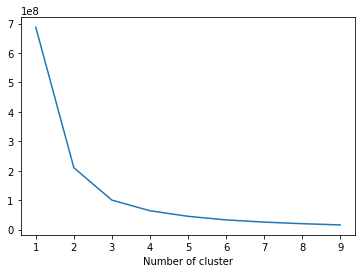

In [10]:
sse={}

tx_recency = df[['recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [11]:
sse

{1: 687454270.0702527,
 2: 210069613.9349934,
 3: 99994434.6658616,
 4: 63850222.29722127,
 5: 44946906.107882716,
 6: 32690492.701335773,
 7: 25247068.862735443,
 8: 19866967.596166234,
 9: 15692467.111606712}

In [12]:
# creating labels and assigning them to tree percentile groups 
r_labels = range(3, 0, -1)
r_groups = pd.qcut(df.recency, q = 3, labels = r_labels)

f_labels = range(1, 4)
f_groups = pd.qcut(df.frequency, q = 3, labels = f_labels)

m_labels = range(1, 4)
m_groups = pd.qcut(df.monetary, q = 3, labels = m_labels)

In [13]:
# making a new column for group labels
df['R'] = r_groups.values

df['F'] = f_groups.values

df['M'] = m_groups.values

# summing up the three columns
df['RFM_segment'] = df.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)

df['RFM_score'] = df[['R', 'F', 'M']].sum(axis = 1)

df.head()

,monetary,frequency,recency,R,F,M,RFM_segment,RFM_score
customer_id,,,,,,,,
22086,777,9,232,1,2,2,122,5
2290,1555,16,115,2,3,3,233,8
26377,336,5,43,3,1,1,311,5
24650,1189,12,64,3,3,3,333,9
12883,1229,12,23,3,3,3,333,9


In [14]:
# calculate averae values for each RFM
rfm_agg = df.groupby('RFM_score').agg({'recency' : 'mean',
                                       'frequency' : 'mean',
                                       'monetary' : ['mean', 'count']})

rfm_agg.round(1).head()

recency frequency monetary      
             mean      mean     mean count
RFM_score                                 
3           366.4       6.0    528.3  5138
4           228.1       7.2    659.3  5222
5           180.3       8.3    759.4  6946
6           164.7       9.8    930.4  6274
7           149.3      11.3   1099.3  6707

In [15]:
# clustering
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(df)

# Assigning the clusters to datamart
df['K_Cluster'] = clus.labels_

df.head()

,monetary,frequency,recency,R,F,M,RFM_segment,RFM_score,K_Cluster
customer_id,,,,,,,,,
22086,777,9,232,1,2,2,122,5,2
2290,1555,16,115,2,3,3,233,8,0
26377,336,5,43,3,1,1,311,5,2
24650,1189,12,64,3,3,3,333,9,1
12883,1229,12,23,3,3,3,333,9,0


In [16]:
# assigning labels from total score
score_labels = ['Bronze', 'Silver', 'Gold']

score_groups = pd.qcut(df.RFM_score, q = 3, labels = score_labels)

df['RFM_level'] = score_groups.values

df.head()

,monetary,frequency,recency,R,F,M,RFM_segment,RFM_score,K_Cluster,RFM_level
customer_id,,,,,,,,,,
22086,777,9,232,1,2,2,122,5,2,Bronze
2290,1555,16,115,2,3,3,233,8,0,Gold
26377,336,5,43,3,1,1,311,5,2,Bronze
24650,1189,12,64,3,3,3,333,9,1,Gold
12883,1229,12,23,3,3,3,333,9,0,Gold


[]

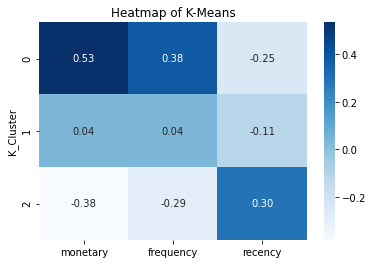

In [17]:
# calculating the proportional gap with total mean

total_avg = df.iloc[:, 0:3].mean()
total_avg

cluster_avg_K = df.groupby('K_Cluster').mean().iloc[:, 0:3]
prop_rfm_K = cluster_avg_K/total_avg - 1

# heatmap with K-means

sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()

[]

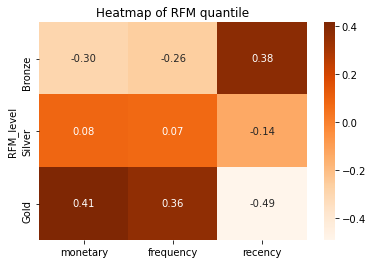

In [18]:
# the mean value in total 

total_avg = df.iloc[:, 0:3].mean()
total_avg

# calculate the proportional gap with total mean

cluster_avg = df.groupby('RFM_level').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1

# heatmap with RFM

sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

In [19]:
df.head()

,monetary,frequency,recency,R,F,M,RFM_segment,RFM_score,K_Cluster,RFM_level
customer_id,,,,,,,,,,
22086,777,9,232,1,2,2,122,5,2,Bronze
2290,1555,16,115,2,3,3,233,8,0,Gold
26377,336,5,43,3,1,1,311,5,2,Bronze
24650,1189,12,64,3,3,3,333,9,1,Gold
12883,1229,12,23,3,3,3,333,9,0,Gold


In [20]:
df.RFM_level.unique()

['Bronze', 'Gold', 'Silver']
Categories (3, object): ['Bronze' < 'Silver' < 'Gold']